In [1]:
#Different libraries that we need 

import numpy as np # numerical python for operations on arrays, matrix
import pandas as pd # very efficient for handling databases 
import matplotlib.pyplot as plt # for plots 
import glob # for accessing directories (where the data are)
from scipy import stats # scientific python - for special functions and probability densities 
import re # for regular expressions 
from tqdm import tqdm_notebook as tqdm 
import matplotlib.image as mpimg # Importing images for visualization and learning curves comparison (with/without outliers)
import scipy.optimize as opt # curve fitting 
import matplotlib.patches as patches # Active zones
import matplotlib.path as mplPath

# in order to plot inline, Jupyter Notebook only 
%matplotlib notebook 

# Import Data

In [2]:
# Import all the .csv files 
trackFiles = []
trackFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Track/*.csv')

shapeFiles = []
shapeFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Shapes/*.csv')

relationsFiles = []
relationsFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/NewRelationsFiles/*.csv')

In [3]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    regExpr2 = re.compile(r'p_shape')
    regExpr3 = re.compile(r'p_relations')
    
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    probeShapesFiles = list(filter(lambda i : regExpr2.search(i), shapeFiles))
    probeRelationsFiles = list(filter(lambda i : regExpr3.search(i), relationsFiles))
    
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    shapeFiles = list(filter(lambda i : not regExpr2.search(i), shapeFiles))
    relationsFiles = list(filter(lambda i : not regExpr3.search(i), relationsFiles))
    
    
else : 
    trackFiles = trackFiles 
    shapeFiles = shapeFiles
    relationsFiles = relationsFiles 


In [95]:
probeFiles = []
probeFiles = glob.glob(r"C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleFirstEncounterProbeCsv/Track/*.csv")

probeShapesFiles = []
probeShapesFiles = glob.glob(r"C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleFirstEncounterProbeCsv/Shapes/*.csv")


probeRelationsFiles = []
probeRelationsFiles = glob.glob(r"C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleFirstEncounterProbeCsv/Relations/*.csv")




In [96]:
# Creating list of tracking Data as list of pandas dataframes 
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""
    


#Adding landmark name and color in order to create a new dataframe for shapes

landm_name = {'Shape': ['Triangle Lg', 'Triangle Sm',  'Square Lg', 'Square Sm', 'Circle Lg', 'Circle Sm', 'Food']} 
shape_names = pd.DataFrame(data = landm_name)

color_shapes = pd.DataFrame(data = np.linspace(0,1,7), columns= ['Color'])

shapeData = []
for i in tqdm(range(0,len(shapeFiles))) : 
    shapeData.append(pd.read_csv(shapeFiles[i], names = ["X", "Y", "Angle"]))
    shapeData[i] = pd.concat([shape_names,shapeData[i]], axis = 1)
    shapeData[i] = pd.concat([shapeData[i], color_shapes], axis = 1)
    
    """_shapes.csv files:
    Columns: X(m), Y(m), A(deg):
    X(m): x coordinate of the shape center @ grid frame of reference
    Y(m): y coordinate of the shape center @ grid frame of reference
    A(deg): Shape orientation
    Rows: "Triangle Lg", "Triangle Sm", "Square Lg", "Square Sm", "Circle Lg", "Circle Sm", "Food", """
    
    
relationsData = []
for i in tqdm(range(0,len(relationsFiles))) : 
    relationsData.append(pd.read_csv(relationsFiles[i]).drop(columns = ['Unnamed: 0']))

    """_relations.csv files:
       Columns: T(s), D_F(m), A_E(deg), L_"Triangle Lg"(bool), L_"Triangle Sm"(bool), L_"Square Lg"(bool), L_"Square Sm"(bool), L_"Circle Lg"(bool), L_"Circle Sm"(bool), L_"Food"(bool), 
       T: camera frame time
       D_F: distance to the food
       A_E: heading angle error (food_vec - head_vec, 0..90 deg)
       L_"x": Is shape "x" adjacent to the head position? 0:no, 1:yes"""

# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFiles))) : 
    probeData.append(pd.read_csv(probeFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    
probeRelationsData = [] 
for i in tqdm(range(0,len(probeRelationsFiles))) : 
    probeRelationsData.append(pd.read_csv(probeRelationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 'ActiveZoneTriangleLarge', 'ActiveZoneTriangleSmall', 'ActiveZoneSquareLarge', 'ActiveZoneSquareSmall' ,'ActiveZoneCircleLarge', 'ActiveZoneCircleSmall', 'ActiveZoneFood']))
    


In [5]:
#Quick consistency check 
len(trackData) == len(shapeData) ==len(relationsData)

True

# Trajectories Plotting 

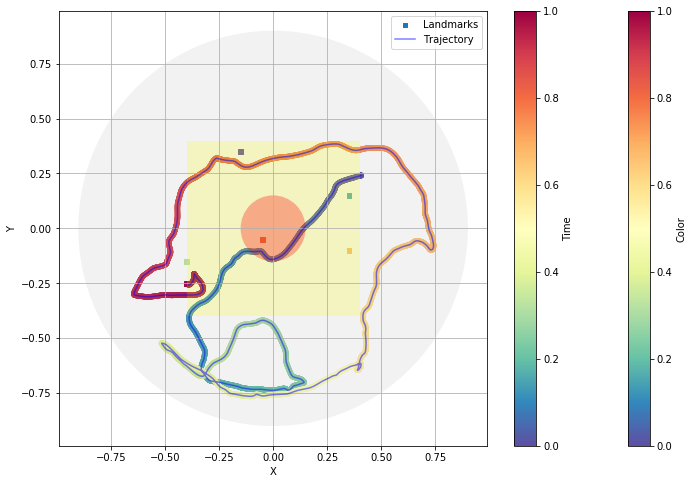

In [6]:

#Select trajectory number (based on number of videos = 199 + 14(probes))
traj_number = 3



# Plotting each trajectory with Spectral colormap based on time --> as James did in matlab 
# The colormap is related to time --> take a look on the side of the plot 

#plt.figure()
""

fig, ax = plt.subplots( figsize = (12,8))
circ = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square = patches.Rectangle((-0.4,-0.4), 0.8, 0.8, alpha = 0.2, fc = 'yellow')
circ2 = patches.Circle((0, 0), 0.15, alpha=0.30, fc='red')

ax.add_patch(circ)
ax.add_patch(square)
ax.add_patch(circ2)


plt.xlim(-1,1)
plt.ylim(-1,1)
# Setting positions of landmarks and trajectory points 
shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax, marker = 's', style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r')
trackData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax,c = 'Time', cmap = 'Spectral_r')

# Adding polygonal chain in order to see the trajectory and get vector length later 
trackData[traj_number].plot.line(x = "X", y = 'Y', ax = ax, style = 'b', alpha = 0.5, grid = True, label = 'Trajectory')

plt.Axes.autoscale(ax)

# Detecting B-Scans 

In [7]:
# Check food associated shape by finding the closest landmark to food 
def euclidean_distance(x1, y1, x2, y2): 
    dist = np.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))
    return dist 

In [8]:
trackData_new = trackData.copy()

In [9]:
for i in tqdm(range(0,len(trackData))):
    prova = trackData_new[i].drop(columns= ['EODRate', 'DistanceXEODPulse', 'HeadSpeed', 'DistanceXESCAN'])
    trackData_new[i] = prova.diff()
    trackData_new[i] = trackData_new[i].dropna()
    trackData_new[i] = trackData_new[i].reset_index(drop = True)
    
    pivot = []
    #pivot.append(0.0)
    
    for index, row in trackData_new[i].iterrows():
        pivot.append(euclidean_distance(row['X'], row['Y'],0,0))
    
    pivotArray = np.asarray(pivot)
    #pivotArray = pivotArray[~np.isnan(pivotArray)] #removing nan
    trackData_new[i]['DistanceNextPoint'] = pivotArray

In [10]:
for i in tqdm(range(0,len(trackData))):

    dot_prod_list = []
    
    for index, row in trackData_new[i].iterrows():
        if index < len(trackData_new[i]) - 1:
            dot_prod_list.append(trackData_new[i].iloc[index + 1, 4] * trackData_new[i].iloc[index, 4] *np.cos(trackData_new[i].iloc[index+1, 3]))
        else: 
            dot_prod_list.append(0)
    dot_prod_array = np.asarray(dot_prod_list)
    b_scans_array = dot_prod_array < 0 # Boolean mask --> True if b-scans is happening 
    trackData_new[i]['B-ScansT/F'] = b_scans_array.astype(int)
    a1 = trackData_new[i].loc[[0],:]
    trackData_new[i] =pd.concat([a1, trackData_new[i]], ignore_index = True)

In [11]:
for i in tqdm(range(0,len(trackData))):
    trackData_new[i]['X'] = trackData[i]['X']
    trackData_new[i]['Y'] = trackData[i]['Y']

In [12]:
for i in tqdm(range(0, len(relationsData))):
    relationsData[i]['B-ScansT/F'] = trackData_new[i]['B-ScansT/F']

In [13]:
b_scans_circle_small = []
b_scans_circle_large = []
b_scans_square_small = []
b_scans_square_large = []
b_scans_triangle_small = []
b_scans_triangle_large = []

b_scans_food = []

for i in tqdm(range(0,len(relationsData))):
    b_scans_circle_small.append(np.where(relationsData[i]['B-ScansT/F'] == relationsData[i]['ActiveZoneCircleSmall'], relationsData[i]['B-ScansT/F'], relationsData[i]['ActiveZoneCircleSmall']))
    b_scans_circle_large.append(np.where(relationsData[i]['B-ScansT/F'] == relationsData[i]['ActiveZoneCircleLarge'], relationsData[i]['B-ScansT/F'], relationsData[i]['ActiveZoneCircleLarge']))
    b_scans_square_small.append(np.where(relationsData[i]['B-ScansT/F'] == relationsData[i]['ActiveZoneSquareSmall'], relationsData[i]['B-ScansT/F'], relationsData[i]['ActiveZoneSquareSmall']))
    b_scans_square_large.append(np.where(relationsData[i]['B-ScansT/F'] == relationsData[i]['ActiveZoneSquareLarge'], relationsData[i]['B-ScansT/F'], relationsData[i]['ActiveZoneSquareLarge']))
    b_scans_triangle_small.append(np.where(relationsData[i]['B-ScansT/F'] == relationsData[i]['ActiveZoneTriangleSmall'], relationsData[i]['B-ScansT/F'], relationsData[i]['ActiveZoneTriangleSmall']))
    b_scans_triangle_large.append(np.where(relationsData[i]['B-ScansT/F'] == relationsData[i]['ActiveZoneTriangleLarge'], relationsData[i]['B-ScansT/F'], relationsData[i]['ActiveZoneTriangleLarge']))
    b_scans_food.append(np.where(relationsData[i]['B-ScansT/F'] == relationsData[i]['ActiveZoneFood'], relationsData[i]['B-ScansT/F'], relationsData[i]['ActiveZoneFood']))


# Plottt

<IPython.core.display.Javascript object>


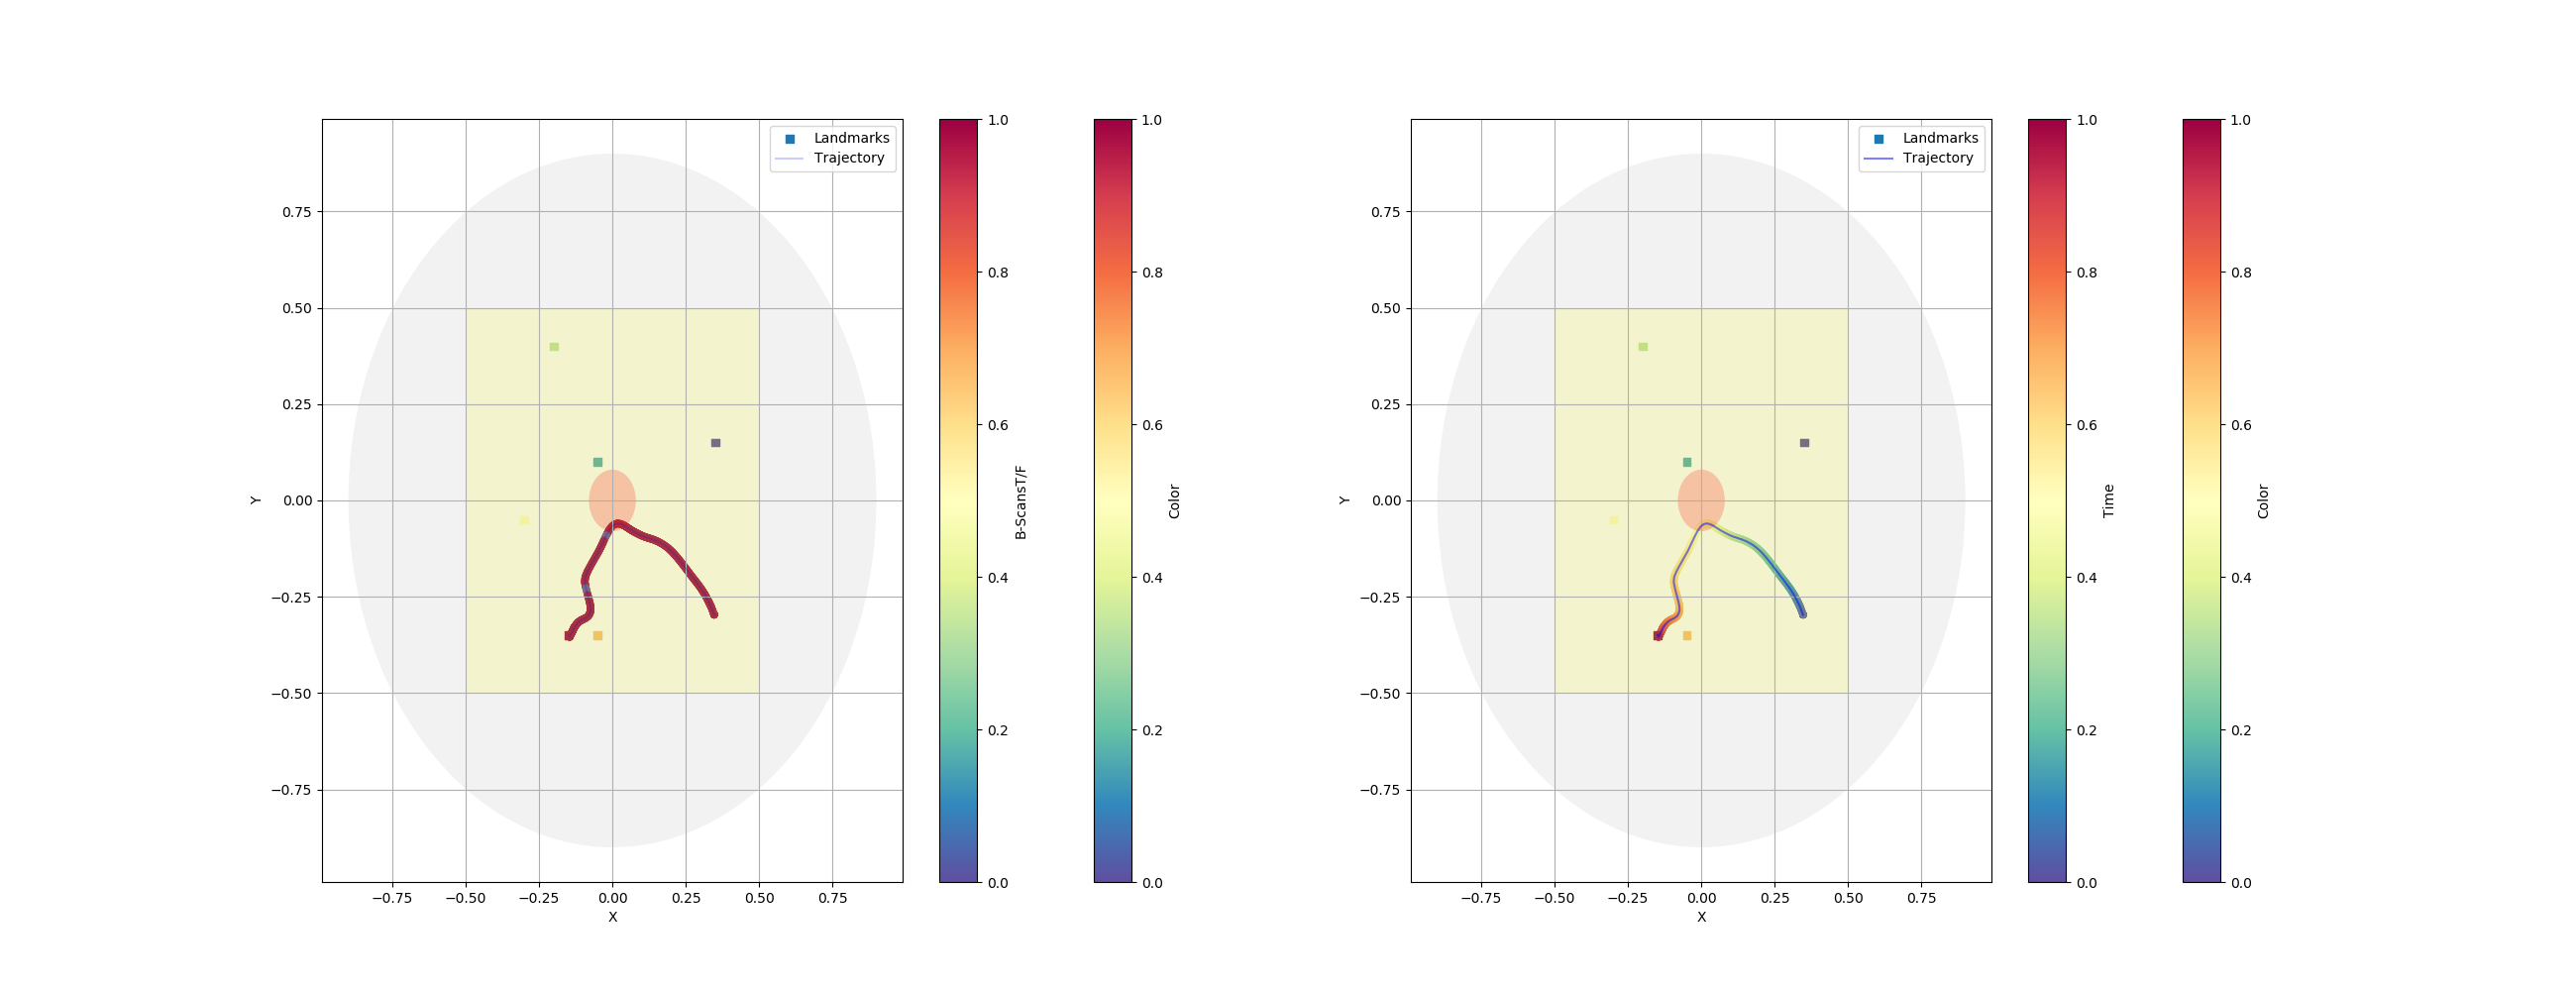

In [19]:
%matplotlib notebook 

#Select trajectory number (based on number of videos = 199 + 14(probes))
traj_number = 0

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (26,10))

circ = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square = patches.Rectangle((-0.5,-0.5), 1, 1, alpha = 0.15, fc = 'yellow')
circ2 = patches.Circle((0, 0), 0.08, alpha=0.20, fc='red')

circ1 = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square1 = patches.Rectangle((-0.5,-0.5), 1, 1, alpha = 0.15, fc = 'yellow')
circ12 = patches.Circle((0, 0), 0.08, alpha=0.20, fc='red')


ax1.add_patch(circ)
ax1.add_patch(square)
ax1.add_patch(circ2)

ax2.add_patch(circ1)
ax2.add_patch(square1)
ax2.add_patch(circ12)

 
plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)

shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax1, marker = 's', s = 30,style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r', alpha =1)
trackData_new[traj_number].plot.scatter(x = "X", y = "Y", ax = ax1, c = "B-ScansT/F",  cmap = 'Spectral', alpha = 1)

trackData_new[traj_number].plot.line(x = "X", y = 'Y', ax = ax1, style = 'b', alpha = 0.2, grid = True, label = 'Trajectory')

# Setting positions of landmarks and trajectory points 
shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax2, marker = 's', s = 30, style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r', alpha =1)
trackData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax2,c = 'Time', cmap = 'Spectral_r')

# Adding polygonal chain in order to see the trajectory and get vector length later 
trackData[traj_number].plot.line(x = "X", y = 'Y', ax = ax2, style = 'b', alpha = 0.5, grid = True, label = 'Trajectory')


plt.Axes.autoscale(ax1)
plt.Axes.autoscale(ax2)

## Fish A and B 

In [28]:
df_for_sampling_density_analysis = []

for i in tqdm(range(0,len(trackFiles))) :
    df_for_sampling_density_analysis.append(pd.concat([trackData[i]['Time'],
                                                       trackData[i]['X'], trackData[i]['Y'],trackData[i]['DistanceXEODPulse'], relationsData[i]['ActiveZoneTriangleLarge'],
                                                        relationsData[i]['ActiveZoneTriangleSmall'], relationsData[i]['ActiveZoneSquareLarge'], relationsData[i]['ActiveZoneSquareSmall'],relationsData[i]['ActiveZoneCircleLarge'],
                                                       relationsData[i]['ActiveZoneCircleSmall'], relationsData[i]['ActiveZoneFood']], axis=1, keys=['Time', 'X', 'Y', 'SamplingDensity','ActiveZoneTriangleLarge', 'ActiveZoneTriangleSmall', 'ActiveZoneSquareLarge', 'ActiveZoneSquareSmall' ,'ActiveZoneCircleLarge', 'ActiveZoneCircleSmall', 'ActiveZoneFood']))
    df_for_sampling_density_analysis[i] = df_for_sampling_density_analysis[i].replace([np.inf,-np.inf], 0)

In [100]:
df_for_sampling_density_analysis_probe = []

for i in tqdm(range(0,len(probeData))) :
    df_for_sampling_density_analysis_probe.append(pd.concat([probeData[i]['Time'],
                                                       probeData[i]['X'], probeData[i]['Y'], probeData[i]['DistanceXEODPulse'], probeRelationsData[i]['ActiveZoneTriangleLarge'],
                                                        probeRelationsData[i]['ActiveZoneTriangleSmall'], probeRelationsData[i]['ActiveZoneSquareLarge'], probeRelationsData[i]['ActiveZoneSquareSmall'], probeRelationsData[i]['ActiveZoneCircleLarge'],
                                                        probeRelationsData[i]['ActiveZoneCircleSmall'], probeRelationsData[i]['ActiveZoneFood']], axis=1, keys=['Time', 'X', 'Y', 'SamplingDensity','ActiveZoneTriangleLarge', 'ActiveZoneTriangleSmall', 'ActiveZoneSquareLarge', 'ActiveZoneSquareSmall' ,'ActiveZoneCircleLarge', 'ActiveZoneCircleSmall', 'ActiveZoneFood']))
    df_for_sampling_density_analysis_probe[i] = df_for_sampling_density_analysis_probe[i].replace([np.inf,-np.inf], 0)
    df_for_sampling_density_analysis_probe[i] = df_for_sampling_density_analysis_probe[i].dropna()
    #df_for_sampling_density_analysis[i]['SamplingDensity'] = (df_for_sampling_density_analysis[i]['SamplingDensity'] - df_for_sampling_density_analysis[i]['SamplingDensity'].min() )/(df_for_sampling_density_analysis[i]['SamplingDensity'].max() - df_for_sampling_density_analysis[i]['SamplingDensity'].min())

In [101]:
indexFishA = []
indexFishB = [] 
indexFishC = [] 
indexFishD = [] 

for i in range(0,len(trackFiles)):
    if trackFiles[i][-12] == 'A':
        indexFishA.append(i)
        
    elif trackFiles[i][-12] == 'B':
        indexFishB.append(i)
        
    elif trackFiles[i][-12] == 'C':
        indexFishC.append(i)
        
    elif trackFiles[i][-12] == 'D':
        indexFishD.append(i)      
        
indexFishAProbe = []
indexFishBProbe = [] 
indexFishCProbe = [] 
indexFishDProbe = [] 

for i in range(0,len(probeFiles)):
    if probeFiles[i][-13] == 'A':
        indexFishAProbe.append(i)
        
    elif probeFiles[i][-13] == 'B':
        indexFishBProbe.append(i)
        
    elif probeFiles[i][-13] == 'C':
        indexFishCProbe.append(i)
        
    elif probeFiles[i][-13] == 'D':
        indexFishDProbe.append(i)      


In [102]:
dataFishA = []
dataFishB = []
dataFishC = []
dataFishD = []

#for i in range(0, len(df_for_sampling_density_analysis)):cd
for j in indexFishA:
    dataFishA.append(df_for_sampling_density_analysis[j])
for j in indexFishB:
    dataFishB.append(df_for_sampling_density_analysis[j])
for j in indexFishC:
    dataFishC.append(df_for_sampling_density_analysis[j])
for j in indexFishD:
    dataFishD.append(df_for_sampling_density_analysis[j])
    
    
dataProbeFishA = []
dataProbeFishB = []
dataProbeFishC = []
dataProbeFishD = []

for j in indexFishAProbe:
    dataProbeFishA.append(df_for_sampling_density_analysis_probe[j])
for j in indexFishBProbe:
    dataProbeFishB.append(df_for_sampling_density_analysis_probe[j])
for j in indexFishCProbe:
    dataProbeFishC.append(df_for_sampling_density_analysis_probe[j])
for j in indexFishDProbe:
    dataProbeFishD.append(df_for_sampling_density_analysis_probe[j])
    
    

In [31]:
bs_fishA_circle_small = []
bs_fishA_circle_large = []
bs_fishA_square_small = []
bs_fishA_square_large = []
bs_fishA_triangle_small = []
bs_fishA_triangle_large = []
bs_fishA_food = []



for j in indexFishA:
    bs_fishA_circle_small.append(b_scans_circle_small[j])
    bs_fishA_circle_large.append(b_scans_circle_large[j])
    bs_fishA_square_small.append(b_scans_square_small[j])
    bs_fishA_square_large.append(b_scans_square_large[j])
    bs_fishA_triangle_small.append(b_scans_triangle_small[j])
    bs_fishA_triangle_large.append(b_scans_triangle_large[j])
    bs_fishA_food.append(b_scans_food[j])
    
    

In [32]:
bs_fishB_circle_small = []
bs_fishB_circle_large = []
bs_fishB_square_small = []
bs_fishB_square_large = []
bs_fishB_triangle_small = []
bs_fishB_triangle_large = []
bs_fishB_food = []

for j in indexFishB:
    bs_fishB_circle_small.append(b_scans_circle_small[j])
    bs_fishB_circle_large.append(b_scans_circle_large[j])
    bs_fishB_square_small.append(b_scans_square_small[j])
    bs_fishB_square_large.append(b_scans_square_large[j])
    bs_fishB_triangle_small.append(b_scans_triangle_small[j])
    bs_fishB_triangle_large.append(b_scans_triangle_large[j])
    bs_fishB_food.append(b_scans_food[j])

In [33]:
occurences_bs_fishA_circle_small = []
occurences_bs_fishA_circle_large = []
occurences_bs_fishA_square_small = []
occurences_bs_fishA_square_large = []
occurences_bs_fishA_triangle_small = []
occurences_bs_fishA_triangle_large = []
occurences_bs_fishA_food = []

for i in range(0,len(indexFishA)):
    occurences_bs_fishA_circle_small.append(np.count_nonzero(bs_fishA_circle_small[i]))
    occurences_bs_fishA_circle_large.append(np.count_nonzero(bs_fishA_circle_large[i]))
    occurences_bs_fishA_square_small.append(np.count_nonzero(bs_fishA_square_small[i]))
    occurences_bs_fishA_square_large.append(np.count_nonzero(bs_fishA_square_large[i]))
    occurences_bs_fishA_triangle_small.append(np.count_nonzero(bs_fishA_triangle_small[i]))
    occurences_bs_fishA_triangle_large.append(np.count_nonzero(bs_fishA_triangle_large[i]))
    occurences_bs_fishA_food.append(np.count_nonzero(bs_fishA_food[i]))



In [39]:
occurences_bs_fishB_circle_small = []
occurences_bs_fishB_circle_large = []
occurences_bs_fishB_square_small = []
occurences_bs_fishB_square_large = []
occurences_bs_fishB_triangle_small = []
occurences_bs_fishB_triangle_large = []
occurences_bs_fishB_food = []

for i in range(0,len(indexFishB)):
    occurences_bs_fishB_circle_small.append(np.count_nonzero(bs_fishB_circle_small[i]))
    occurences_bs_fishB_circle_large.append(np.count_nonzero(bs_fishB_circle_large[i]))
    occurences_bs_fishB_square_small.append(np.count_nonzero(bs_fishB_square_small[i]))
    occurences_bs_fishB_square_large.append(np.count_nonzero(bs_fishB_square_large[i]))
    occurences_bs_fishB_triangle_small.append(np.count_nonzero(bs_fishB_triangle_small[i]))
    occurences_bs_fishB_triangle_large.append(np.count_nonzero(bs_fishB_triangle_large[i]))
    occurences_bs_fishB_food.append(np.count_nonzero(bs_fishB_food[i]))



In [40]:
earlyA_ends_at = 5
lateA_starts_at = 56

earlyB_ends_at = 7 
lateB_starts_at = 58

In [41]:
early_bsA_circle_small = sum(occurences_bs_fishA_circle_small[:earlyA_ends_at])
late_bsA_circle_small = sum(occurences_bs_fishA_circle_small[:lateA_starts_at])

early_bsA_circle_large = sum(occurences_bs_fishA_circle_large[:earlyA_ends_at])
late_bsA_circle_large = sum(occurences_bs_fishA_circle_large[:lateA_starts_at])

early_bsA_square_small = sum(occurences_bs_fishA_square_small[:earlyA_ends_at])
late_bsA_square_small = sum(occurences_bs_fishA_square_small[:lateA_starts_at])

early_bsA_square_large = sum(occurences_bs_fishA_square_large[:earlyA_ends_at])
late_bsA_square_large = sum(occurences_bs_fishA_square_large[:lateA_starts_at])

early_bsA_triangle_small = sum(occurences_bs_fishA_triangle_small[:earlyA_ends_at])
late_bsA_triangle_small = sum(occurences_bs_fishA_triangle_small[:lateA_starts_at])

early_bsA_triangle_large = sum(occurences_bs_fishA_triangle_large[:earlyA_ends_at])
late_bsA_triangle_large = sum(occurences_bs_fishA_triangle_large[:lateA_starts_at])

early_bsA_food = sum(occurences_bs_fishA_food[:earlyA_ends_at])
late_bsA_food = sum(occurences_bs_fishA_food[:lateA_starts_at])



<IPython.core.display.Javascript object>


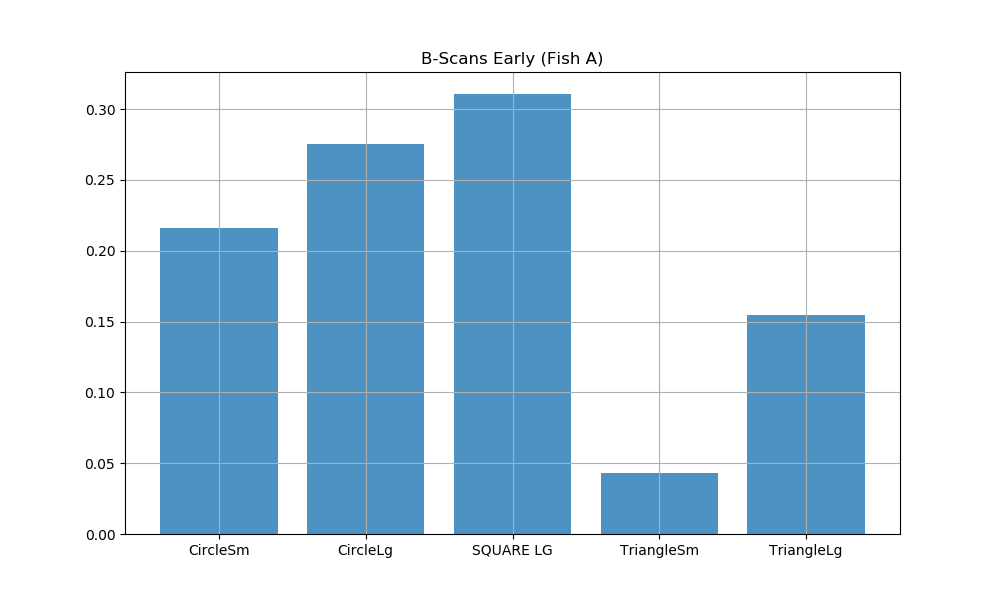

In [42]:
early_bsA = [early_bsA_circle_small, early_bsA_circle_large, early_bsA_square_large, early_bsA_triangle_small, early_bsA_triangle_large]
early_bsA = np.asarray(early_bsA)
early_bsA_norm = early_bsA / early_bsA.sum()

x_early_bsA = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("B-Scans Early (Fish A)")
plt.bar(x_early_bsA, early_bsA_norm,  alpha = 0.8)
plt.grid()
plt.xticks(x_early_bsA, ('CircleSm', 'CircleLg','SQUARE LG', 'TriangleSm', 'TriangleLg'))#,'Food'))
plt.savefig("Images/Shuffle/B-Scans/B-Scans_FishA_Early.png")

In [43]:
early_bsB_square_small = sum(occurences_bs_fishB_square_small[:earlyB_ends_at])
late_bsB_square_small = sum(occurences_bs_fishB_square_small[:lateB_starts_at])

early_bsB_circle_large = sum(occurences_bs_fishB_circle_large[:earlyB_ends_at])
late_bsB_circle_large = sum(occurences_bs_fishB_circle_large[:lateB_starts_at])

early_bsB_square_small = sum(occurences_bs_fishB_square_small[:earlyB_ends_at])
late_bsB_square_small = sum(occurences_bs_fishB_square_small[:lateB_starts_at])

early_bsB_square_large = sum(occurences_bs_fishB_square_large[:earlyB_ends_at])
late_bsB_square_large = sum(occurences_bs_fishB_square_large[:lateB_starts_at])

early_bsB_triangle_small = sum(occurences_bs_fishB_triangle_small[:earlyB_ends_at])
late_bsB_triangle_small = sum(occurences_bs_fishB_triangle_small[:lateB_starts_at])

early_bsB_triangle_large = sum(occurences_bs_fishB_triangle_large[:earlyB_ends_at])
late_bsB_triangle_large = sum(occurences_bs_fishB_triangle_large[:lateB_starts_at])

early_bsB_food = sum(occurences_bs_fishB_food[:earlyB_ends_at])
late_bsB_food = sum(occurences_bs_fishB_food[:lateB_starts_at])



<IPython.core.display.Javascript object>


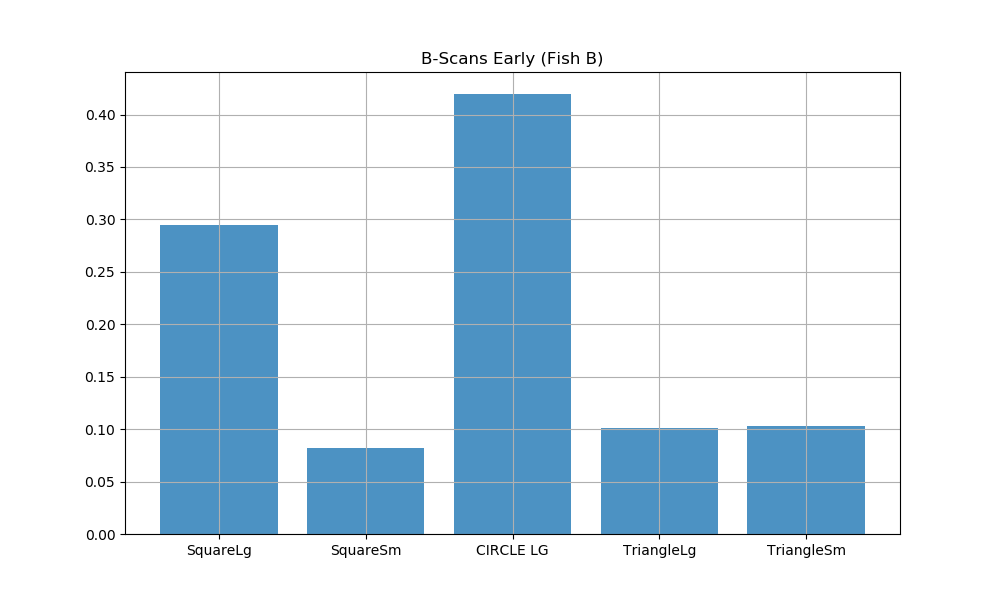

In [44]:
early_bsB = [early_bsB_square_large, early_bsB_square_small, early_bsB_circle_large, early_bsB_triangle_large, early_bsB_triangle_small]
early_bsB = np.asarray(early_bsB)
early_bsB_norm = early_bsB / early_bsB.sum()

x_early_bsB = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("B-Scans Early (Fish B)")
plt.bar(x_early_bsB, early_bsB_norm,  alpha = 0.8)
plt.grid()
plt.xticks(x_early_bsB, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/B-Scans/B-Scans_FishB_Early.png")

## Late 

<IPython.core.display.Javascript object>


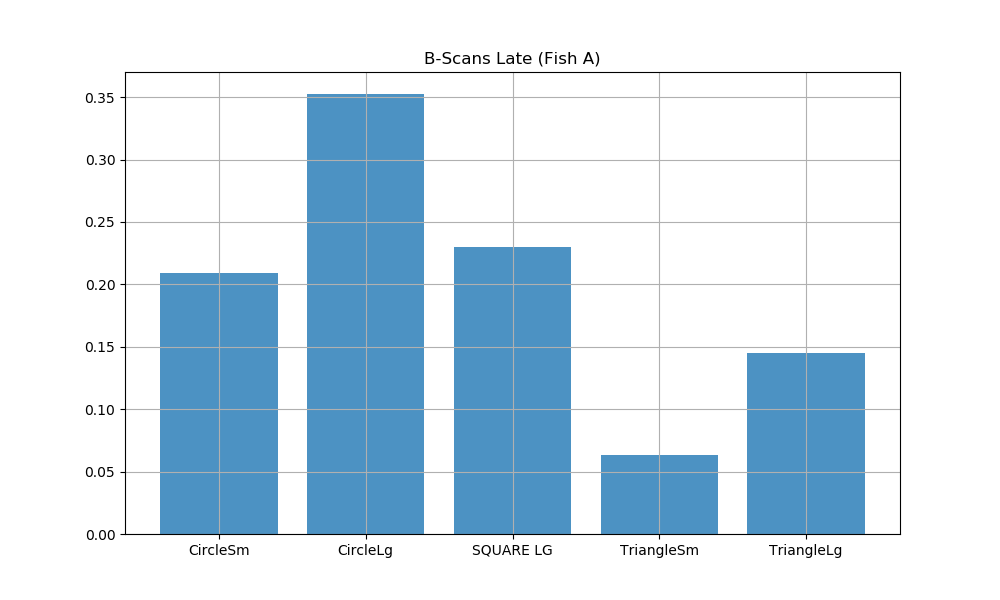

In [45]:
late_bsA = [late_bsA_circle_small, late_bsA_circle_large, late_bsA_square_large, late_bsA_triangle_small, late_bsA_triangle_large]
late_bsA = np.asarray(late_bsA)
late_bsA_norm = late_bsA / late_bsA.sum()

x_late_bsA = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("B-Scans Late (Fish A)")
plt.bar(x_late_bsA, late_bsA_norm,  alpha = 0.8)
plt.grid()
plt.xticks(x_late_bsA, ('CircleSm', 'CircleLg','SQUARE LG', 'TriangleSm', 'TriangleLg'))#,'Food'))
plt.savefig("Images/Shuffle/B-Scans/B-Scans_FishA_Late.png")

<IPython.core.display.Javascript object>


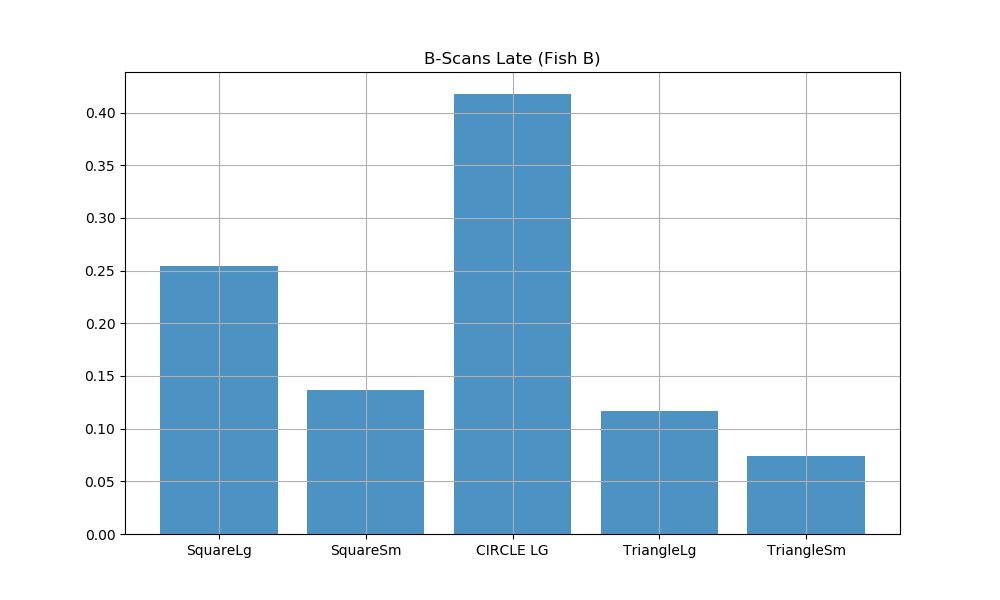

In [46]:
late_bsB = [late_bsB_square_large, late_bsB_square_small, late_bsB_circle_large, late_bsB_triangle_large, late_bsB_triangle_small]
late_bsB = np.asarray(late_bsB)
late_bsB_norm = late_bsB / late_bsB.sum()

x_late_bsB = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("B-Scans Late (Fish B)")
plt.bar(x_late_bsB, late_bsB_norm,  alpha = 0.8)
plt.grid()
plt.xticks(x_late_bsB, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/B-Scans/B-Scans_FishB_Late.png")

## Probe Trials 

In [103]:
probeData_new = probeData.copy()

In [104]:
for i in tqdm(range(0,len(probeData))):
    prova = probeData_new[i].drop(columns= ['EODRate', 'DistanceXEODPulse', 'HeadSpeed', 'DistanceXESCAN'])
    probeData_new[i] = prova.diff()
    probeData_new[i] = probeData_new[i].dropna()
    probeData_new[i] = probeData_new[i].reset_index(drop = True)
    
    pivot_probe = []
    #pivot.append(0.0)
    
    for index, row in probeData_new[i].iterrows():
        pivot_probe.append(euclidean_distance(row['X'], row['Y'],0,0))
    
    pivotArray_probe = np.asarray(pivot_probe)
    #pivotArray = pivotArray[~np.isnan(pivotArray)] #removing nan
    probeData_new[i]['DistanceNextPoint'] = pivotArray_probe

In [105]:
for i in tqdm(range(0,len(probeData))):

    dot_prod_list_probe = []
    
    for index, row in probeData_new[i].iterrows():
        if index < len(probeData_new[i]) - 1:
            dot_prod_list_probe.append(probeData_new[i].iloc[index + 1, 4] * probeData_new[i].iloc[index, 4] *np.cos(probeData_new[i].iloc[index+1, 3]))
        else: 
            dot_prod_list_probe.append(0)
    dot_prod_array_probe = np.asarray(dot_prod_list_probe)
    b_scans_array_probe = dot_prod_array_probe < 0 # Boolean mask --> True if b-scans is happening 
    probeData_new[i]['B-ScansT/F'] = b_scans_array_probe.astype(int)
    a1_probe = probeData_new[i].loc[[0],:]
    probeData_new[i] =pd.concat([a1_probe, probeData_new[i]], ignore_index = True)

In [106]:
for i in tqdm(range(0,len(probeData))):
    probeData_new[i]['X'] = probeData[i]['X']
    probeData_new[i]['Y'] = probeData[i]['Y']

In [107]:
for i in tqdm(range(0, len(probeRelationsData))):
    probeRelationsData[i]['B-ScansT/F'] = probeData_new[i]['B-ScansT/F']

In [109]:
b_scans_circle_small_probe = []
b_scans_circle_large_probe = []
b_scans_square_small_probe = []
b_scans_square_large_probe = []
b_scans_triangle_small_probe = []
b_scans_triangle_large_probe = []



for i in tqdm(range(0,len(probeRelationsData))):
    b_scans_circle_small_probe.append(np.where(probeRelationsData[i]['B-ScansT/F'] == probeRelationsData[i]['ActiveZoneCircleSmall'], probeRelationsData[i]['B-ScansT/F'], probeRelationsData[i]['ActiveZoneCircleSmall']))
    b_scans_circle_large_probe.append(np.where(probeRelationsData[i]['B-ScansT/F'] == probeRelationsData[i]['ActiveZoneCircleLarge'], probeRelationsData[i]['B-ScansT/F'], probeRelationsData[i]['ActiveZoneCircleLarge']))
    b_scans_square_small_probe.append(np.where(probeRelationsData[i]['B-ScansT/F'] == probeRelationsData[i]['ActiveZoneSquareSmall'], probeRelationsData[i]['B-ScansT/F'], probeRelationsData[i]['ActiveZoneSquareSmall']))
    b_scans_square_large_probe.append(np.where(probeRelationsData[i]['B-ScansT/F'] == probeRelationsData[i]['ActiveZoneSquareLarge'], probeRelationsData[i]['B-ScansT/F'], probeRelationsData[i]['ActiveZoneSquareLarge']))
    b_scans_triangle_small_probe.append(np.where(probeRelationsData[i]['B-ScansT/F'] == probeRelationsData[i]['ActiveZoneTriangleSmall'], probeRelationsData[i]['B-ScansT/F'], probeRelationsData[i]['ActiveZoneTriangleSmall']))
    b_scans_triangle_large_probe.append(np.where(probeRelationsData[i]['B-ScansT/F'] == probeRelationsData[i]['ActiveZoneTriangleLarge'], probeRelationsData[i]['B-ScansT/F'], probeRelationsData[i]['ActiveZoneTriangleLarge']))

### Fish A 

In [111]:
bs_fishA_circle_small_probe = []
bs_fishA_circle_large_probe = []
bs_fishA_square_small_probe = []
bs_fishA_square_large_probe = []
bs_fishA_triangle_small_probe = []
bs_fishA_triangle_large_probe = []
bs_fishA_food_probe = []



for j in indexFishAProbe:
    bs_fishA_circle_small_probe.append(b_scans_circle_small_probe[j])
    bs_fishA_circle_large_probe.append(b_scans_circle_large_probe[j])
    bs_fishA_square_small_probe.append(b_scans_square_small_probe[j])
    bs_fishA_square_large_probe.append(b_scans_square_large_probe[j])
    bs_fishA_triangle_small_probe.append(b_scans_triangle_small_probe[j])
    bs_fishA_triangle_large_probe.append(b_scans_triangle_large_probe[j])
    
    
    

In [112]:
occurrences_bs_fishA_circle_small_probe = []
occurrences_bs_fishA_circle_large_probe = []
occurrences_bs_fishA_square_small_probe = []
occurrences_bs_fishA_square_large_probe = []
occurrences_bs_fishA_triangle_small_probe = []
occurrences_bs_fishA_triangle_large_probe = []


for i in range(0,len(indexFishAProbe)):
    occurrences_bs_fishA_circle_small_probe.append(np.count_nonzero(bs_fishA_circle_small_probe[i]))
    occurrences_bs_fishA_circle_large_probe.append(np.count_nonzero(bs_fishA_circle_large_probe[i]))
    occurrences_bs_fishA_square_small_probe.append(np.count_nonzero(bs_fishA_square_small_probe[i]))
    occurrences_bs_fishA_square_large_probe.append(np.count_nonzero(bs_fishA_square_large_probe[i]))
    occurrences_bs_fishA_triangle_small_probe.append(np.count_nonzero(bs_fishA_triangle_small_probe[i]))
    occurrences_bs_fishA_triangle_large_probe.append(np.count_nonzero(bs_fishA_triangle_large_probe[i]))
    



In [115]:
probe_bsA_circle_small = sum(occurrences_bs_fishA_circle_small_probe)

probe_bsA_circle_large = sum(occurrences_bs_fishA_circle_large_probe)

probe_bsA_square_small = sum(occurrences_bs_fishA_square_small_probe)

probe_bsA_square_large = sum(occurrences_bs_fishA_square_large_probe)

probe_bsA_triangle_small = sum(occurrences_bs_fishA_triangle_small_probe)

probe_bsA_triangle_large = sum(occurrences_bs_fishA_triangle_large_probe)



In [116]:
probe_bsA_square_large

32

<IPython.core.display.Javascript object>


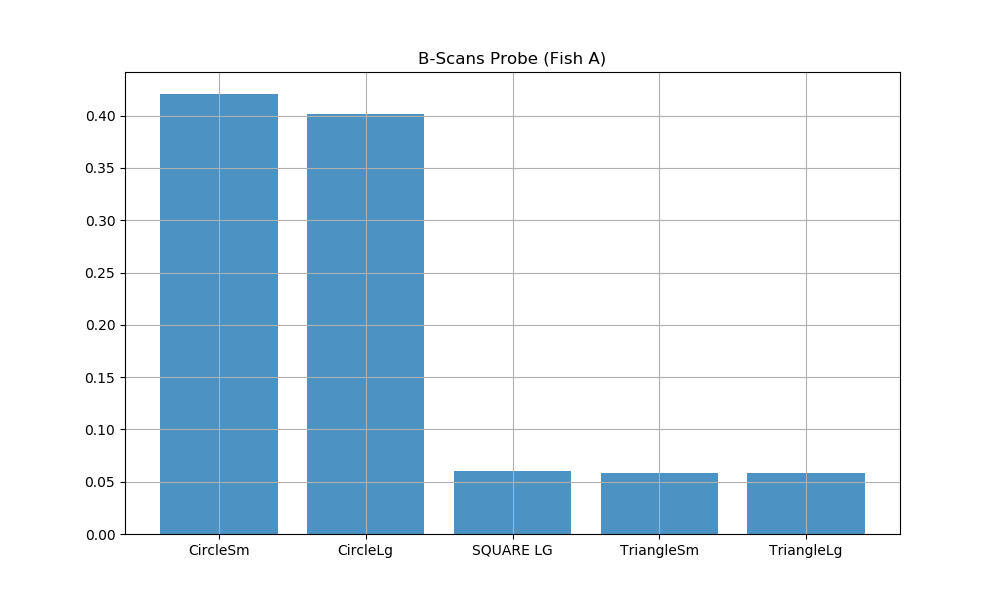

In [117]:
probe_bsA = [probe_bsA_circle_small, probe_bsA_circle_large, probe_bsA_square_large, probe_bsA_triangle_small, probe_bsA_triangle_large]
probe_bsA = np.asarray(probe_bsA)
probe_bsA_norm = probe_bsA / probe_bsA.sum()

x_probe_bsA = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("B-Scans Probe (Fish A)")
plt.bar(x_probe_bsA, probe_bsA_norm,  alpha = 0.8)
plt.grid()
plt.xticks(x_probe_bsA, ('CircleSm', 'CircleLg','SQUARE LG', 'TriangleSm', 'TriangleLg'))#,'Food'))
plt.savefig("Images/Shuffle/B-Scans/B-Scans_FishA_Probe.png")

## Fish B 

In [119]:
bs_fishB_circle_small_probe = []
bs_fishB_circle_large_probe = []
bs_fishB_square_small_probe = []
bs_fishB_square_large_probe = []
bs_fishB_triangle_small_probe = []
bs_fishB_triangle_large_probe = []
bs_fishB_food_probe = []



for j in indexFishBProbe:
    bs_fishB_circle_small_probe.append(b_scans_circle_small_probe[j])
    bs_fishB_circle_large_probe.append(b_scans_circle_large_probe[j])
    bs_fishB_square_small_probe.append(b_scans_square_small_probe[j])
    bs_fishB_square_large_probe.append(b_scans_square_large_probe[j])
    bs_fishB_triangle_small_probe.append(b_scans_triangle_small_probe[j])
    bs_fishB_triangle_large_probe.append(b_scans_triangle_large_probe[j])
    
    
    

In [120]:
occurrences_bs_fishB_circle_small_probe = []
occurrences_bs_fishB_circle_large_probe = []
occurrences_bs_fishB_square_small_probe = []
occurrences_bs_fishB_square_large_probe = []
occurrences_bs_fishB_triangle_small_probe = []
occurrences_bs_fishB_triangle_large_probe = []


for i in range(0,len(indexFishBProbe)):
    occurrences_bs_fishB_circle_small_probe.append(np.count_nonzero(bs_fishB_circle_small_probe[i]))
    occurrences_bs_fishB_circle_large_probe.append(np.count_nonzero(bs_fishB_circle_large_probe[i]))
    occurrences_bs_fishB_square_small_probe.append(np.count_nonzero(bs_fishB_square_small_probe[i]))
    occurrences_bs_fishB_square_large_probe.append(np.count_nonzero(bs_fishB_square_large_probe[i]))
    occurrences_bs_fishB_triangle_small_probe.append(np.count_nonzero(bs_fishB_triangle_small_probe[i]))
    occurrences_bs_fishB_triangle_large_probe.append(np.count_nonzero(bs_fishB_triangle_large_probe[i]))
    



In [121]:
probe_bsB_circle_small = sum(occurrences_bs_fishB_circle_small_probe)

probe_bsB_circle_large = sum(occurrences_bs_fishB_circle_large_probe)

probe_bsB_square_small = sum(occurrences_bs_fishB_square_small_probe)

probe_bsB_square_large = sum(occurrences_bs_fishB_square_large_probe)

probe_bsB_triangle_small = sum(occurrences_bs_fishB_triangle_small_probe)

probe_bsB_triangle_large = sum(occurrences_bs_fishB_triangle_large_probe)



<IPython.core.display.Javascript object>


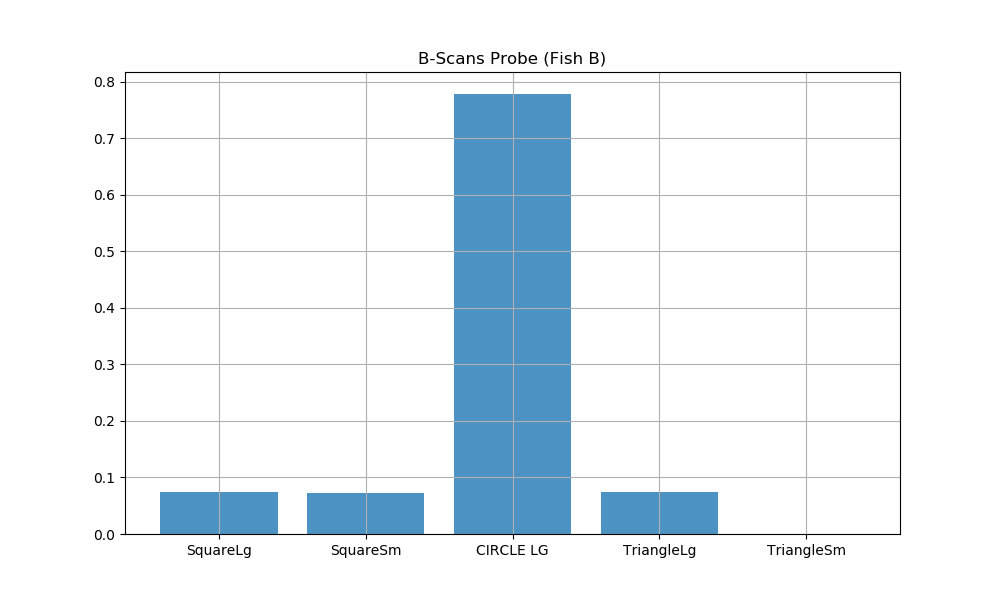

In [123]:
probe_bsB = [probe_bsB_square_large, probe_bsB_square_small, probe_bsB_circle_large, probe_bsB_triangle_large, probe_bsB_triangle_small]
probe_bsB = np.asarray(probe_bsB)
probe_bsB_norm = probe_bsB / probe_bsB.sum()

x_probe_bsB = np.arange(5)

fig,ax = plt.subplots(figsize = (10, 6))
ax.set_title("B-Scans Probe (Fish B)")
plt.bar(x_probe_bsB, probe_bsB_norm,  alpha = 0.8)
plt.grid()
plt.xticks(x_probe_bsB, ('SquareLg', 'SquareSm','CIRCLE LG', 'TriangleLg', 'TriangleSm'))#,'Food'))
plt.savefig("Images/Shuffle/B-Scans/B-Scans_FishB_Probe.png")